In [2]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import cv2
from PIL import Image
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer

# mapping

In [3]:
objects = ["assembler", "constructor"]
label_map = [[1, 0], [0, 1]]

# 

In [4]:
def crop_image(img):
    height, width = img.shape[:2]

    new_width = 1920
    new_height = 1080

    if width < new_width or height < new_height:
        raise Exception(f"The original image size is smaller than the specified crop size: {width}x{height}")

    start_x = (width - new_width) // 2
    start_y = (height - new_height) // 2
    end_x = start_x + new_width
    end_y = start_y + new_height

    cropped_img = img[start_y:end_y, start_x:end_x]

    return cropped_img

# get images

In [5]:
def get_images(task:str, type_object: str, machine: str):
    images_dic = []
    machine = os.path.join(os.getcwd(),"data", task, type_object, machine)
    for subdir, dirs, files in os.walk(machine):
        for file in files:
            img = cv2.imread(os.path.join(machine, file))
            if img is not None:
                if img.shape[0] != 1080:
                    img = crop_image(img)
                img = np.array(img).reshape(len(img), 1920, 3)
                images_dic.append(img)

    return np.array(images_dic)

# preparing data

In [6]:
def get_data(task:str):
    objects = ["assembler", "constructor"]
    label_map = [[1, 0], [0, 1]]
    data = []
    labels = []
    for i in range(len(objects)):
        images = get_images(task, "machine", objects[i])

        for image in images:
            img = np.array(image).reshape(len(image), 1920, 3)
            data.append(np.array(img))
            labels.append(label_map[i])

    return np.array(data), labels


# creating model

In [7]:
conv_base = keras.applications.vgg16.VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(1080, 1920, 3)
)

conv_base.trainable = True
for layer in conv_base.layers[:-3]:
    layer.trainable = False

data_augmentation = keras.Sequential([
    layers.RandomZoom(0.2),
    layers.RandomRotation(0.2),
    layers.RandomContrast(.2),
    layers.RandomBrightness(.1),
    layers.RandomFlip("horizontal_and_vertical")
])

def create_simpleconvnet():
    inputs = keras.Input(shape=(1080, 1920, 3))
    # x = layers.Rescaling(1./255)(inputs)
    x = data_augmentation(inputs)
    x = keras.applications.vgg16.preprocess_input(x)
    x = conv_base(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512)(x)
    x = layers.Dense(128)(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(2, activation='softmax')(x)
    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(learning_rate=1e-6), metrics=["accuracy"])

    model.summary()

    return model

In [60]:
model = create_simpleconvnet()

Model: "model_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1080, 1920, 3)]   0         
                                                                 
 sequential_1 (Sequential)   (None, 1080, 1920, 3)     0         
                                                                 
 tf.__operators__.getitem_1  (None, 1080, 1920, 3)     0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_1 (TFOpLamb  (None, 1080, 1920, 3)     0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 33, 60, 512)       14714688  
                                                                 
 flatten_1 (Flatten)         (None, 1013760)           0  

# training

In [61]:
raw_data, raw_label = get_data("train")

data_train, data_val, labels_train, labels_val = train_test_split(raw_data, raw_label, train_size=0.8)

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="convnet_pretrained_augmentation.tf", save_best_only=True, monitor="val_loss"),
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5) #Stoppen bij gebrek aan verbetering
]

history = model.fit(data_train, np.array(labels_train), validation_data=(data_val, np.array(labels_val)), epochs=100, batch_size=10, callbacks=callbacks)

[1, 0]
[0, 1]
Epoch 1/100
23/23 [==============================] - ETA: 0s - loss: 8.6318 - accuracy: 0.5938 INFO:tensorflow:Assets written to: convnet_pretrained_augmentation.tf\assets


INFO:tensorflow:Assets written to: convnet_pretrained_augmentation.tf\assets


23/23 [==============================] - 372s 16s/step - loss: 8.6318 - accuracy: 0.5938 - val_loss: 3.4977 - val_accuracy: 0.6964
Epoch 2/100
23/23 [==============================] - 353s 15s/step - loss: 5.2218 - accuracy: 0.7366 - val_loss: 3.7336 - val_accuracy: 0.6786
Epoch 3/100
23/23 [==============================] - ETA: 0s - loss: 5.6788 - accuracy: 0.6964 INFO:tensorflow:Assets written to: convnet_pretrained_augmentation.tf\assets


INFO:tensorflow:Assets written to: convnet_pretrained_augmentation.tf\assets


23/23 [==============================] - 354s 16s/step - loss: 5.6788 - accuracy: 0.6964 - val_loss: 1.8819 - val_accuracy: 0.8571
Epoch 4/100
23/23 [==============================] - ETA: 0s - loss: 4.3360 - accuracy: 0.7277 INFO:tensorflow:Assets written to: convnet_pretrained_augmentation.tf\assets


INFO:tensorflow:Assets written to: convnet_pretrained_augmentation.tf\assets


23/23 [==============================] - 379s 17s/step - loss: 4.3360 - accuracy: 0.7277 - val_loss: 1.3376 - val_accuracy: 0.8929
Epoch 5/100
23/23 [==============================] - 371s 16s/step - loss: 2.5745 - accuracy: 0.8080 - val_loss: 2.0909 - val_accuracy: 0.8393
Epoch 6/100
23/23 [==============================] - ETA: 0s - loss: 3.2661 - accuracy: 0.7812 INFO:tensorflow:Assets written to: convnet_pretrained_augmentation.tf\assets


INFO:tensorflow:Assets written to: convnet_pretrained_augmentation.tf\assets


23/23 [==============================] - 377s 16s/step - loss: 3.2661 - accuracy: 0.7812 - val_loss: 0.9618 - val_accuracy: 0.9464
Epoch 7/100
23/23 [==============================] - 370s 16s/step - loss: 2.4926 - accuracy: 0.8259 - val_loss: 1.6419 - val_accuracy: 0.8929
Epoch 8/100
23/23 [==============================] - 370s 16s/step - loss: 2.2648 - accuracy: 0.8438 - val_loss: 1.0808 - val_accuracy: 0.9464
Epoch 9/100
23/23 [==============================] - 370s 16s/step - loss: 1.4164 - accuracy: 0.8705 - val_loss: 1.1514 - val_accuracy: 0.9464
Epoch 10/100
23/23 [==============================] - 368s 16s/step - loss: 1.4719 - accuracy: 0.8750 - val_loss: 1.4548 - val_accuracy: 0.8750
Epoch 11/100
23/23 [==============================] - ETA: 0s - loss: 1.7260 - accuracy: 0.8661 INFO:tensorflow:Assets written to: convnet_pretrained_augmentation.tf\assets


INFO:tensorflow:Assets written to: convnet_pretrained_augmentation.tf\assets


23/23 [==============================] - 373s 16s/step - loss: 1.7260 - accuracy: 0.8661 - val_loss: 0.8118 - val_accuracy: 0.9464


# learning stats

NameError: name 'history' is not defined

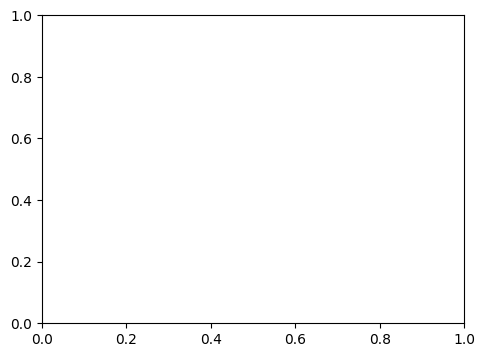

In [8]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation'], loc='upper left')

plt.show()

# testing

In [ ]:
model = keras.models.load_model('convnet_pretrained_augmentation.tf')

raw_data, raw_label = get_data("test")

# Create predictions.
y_pred = model.predict(raw_data)
threshold = 0.5
y_pred_labels = np.array((y_pred > threshold).astype(int))
raw_label = np.array(raw_label)

raw_label = np.array(raw_label.argmax(axis=1))
y_pred = np.array(y_pred.argmax(axis=1))

cm = confusion_matrix(raw_label, y_pred)

print(cm)

sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()